# ThD Cases

In [1]:
import os, sys, shutil, math
import numpy as np
from shutil import rmtree, copy
from matplotlib import pyplot as plt
from matplotlib import gridspec, cm
from PIL import Image, ImageDraw, ImageFont
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import datetime
import subprocess

# Include this pakage
HaMaGeoLib_DIR = "/home/lochy/ASPECT_PROJECT/HaMaGeoLib"
if os.path.abspath(HaMaGeoLib_DIR) not in sys.path:
    sys.path.append(os.path.abspath(HaMaGeoLib_DIR))
from hamageolib.utils.exception_handler import my_assert

# Working directories
local_TwoDSubduction_dir = "/mnt/lochz/ASPECT_DATA/TwoDSubduction"
local_ThDSubduction_dir = "/mnt/lochy/ASPECT_DATA/ThDSubduction" # data directory
# local_ThDSubduction_dir = "/mnt/lochy2/ASPECT_DATA/ThDSubduction" # data back directory
remote_ThDSubduction_dir = "peloton:/group/billengrp-mpi-io/lochy/ThDSubduction"
assert(os.path.isdir(local_ThDSubduction_dir))

# check case name and local directory
case_name_2d = None # set an None initial value to determine whether the 3d case is connected to a 2d case
local_dir_2d = None

# py_temp file and temperature results directory
py_temp_dir = os.path.join(HaMaGeoLib_DIR, "py_temp_files")
RESULT_DIR = os.path.join(HaMaGeoLib_DIR, 'results')
os.makedirs(py_temp_dir, exist_ok=True) # Ensure the directory exists

# paraview scripts directory
SCRIPT_DIR = os.path.join(HaMaGeoLib_DIR, "scripts")

today_date = datetime.datetime.today().strftime("%Y-%m-%d") # Get today's date in YYYY-MM-DD format
py_temp_file = os.path.join(py_temp_dir, f"py_temp_{today_date}.sh")

if not os.path.exists(py_temp_file):
    bash_header = """#!/bin/bash
# =====================================================
# Script: py_temp.sh
# Generated on: {date}
# Description: Temporary Bash script created by Python
# =====================================================

""".format(date=today_date)
    with open(py_temp_file, "w") as f:
        f.write(bash_header)

print(f"File ensured at: {py_temp_file}")

File ensured at: /home/lochy/ASPECT_PROJECT/HaMaGeoLib/py_temp_files/py_temp_2025-09-13.sh


# Utility functions

In [2]:
def get_slab_dimensions_3(x, y, z, Ro, is_chunk):
    '''
    Derives the length along the three dimensions of a subducting slab.

    Inputs:
        x (float): x-coordinate of the slab point.
        y (float): y-coordinate of the slab point.
        z (float): z-coordinate of the slab point.
        Ro (float): Outer radius of the spherical domain.
        is_chunk (bool): Flag indicating whether the geometry is a spherical chunk.

    Returns:
        tuple: A tuple containing (r, w, l):
            - r (float): Radius or z-coordinate depending on whether the geometry is a chunk.
            - w (float): Width of the slab in the y-dimension, or converted width for chunk geometry.
            - l (float): Length of the slab in the x-dimension, or converted length for chunk geometry.
    
    Description:
        - For chunk geometries, converts Cartesian coordinates to spherical coordinates and calculates
          width and length using the outer radius Ro and spherical angles.
        - For non-chunk geometries, returns the z, x, and y coordinates directly as radius, length, and width.
    '''
    if is_chunk:
        # Convert Cartesian coordinates to spherical coordinates for chunk geometry
        r, th1, ph1 = cart2sph(x, y, z)
        w = Ro * (np.pi / 2.0 - th1)  # Calculate width using the spherical angle th1
        l = Ro * ph1  # Calculate length using the spherical angle ph1
    else:
        # For non-chunk geometry, use Cartesian coordinates directly
        r = z
        l = x
        w = y
    
    return r, w, l


def GetSlabDipAngle(case_dir, time_interval_for_slab_morphology, **kwargs):
    '''
    Plots trench position for a single time step and calculates the slab dip angle.

    Inputs:
        case_dir (str): Directory containing the case data.
        time_interval_for_slab_morphology (float): Time interval used to prepare snapshots for slab morphology analysis.
        kwargs (dict): Additional options:
            - silence (bool, default=False): Suppresses warnings if set to True.
            - w_query (float, default=0.0): Width value used for querying trench position.
            - pin_depth (float, default=100e3): Depth value for pinning.
            - crust_only (int, default=0): Flag to specify crustal composition to consider (0: both, 1: upper, 2: lower).

    Returns:
        tuple: Three numpy arrays containing time steps, slab depths, and dip angles.
    
    Description:
        - Initializes VTK options and extracts trench and slab tip positions over multiple time snapshots.
        - Interpolates data to derive the slab dip angle at each time snapshot.
        - Handles missing data files with warnings (unless silenced) and skips to the next snapshot.
    '''
    silence = kwargs.get("silence", False)
    w_query = kwargs.get("w_query", 0.0)
    pin_depth = kwargs.get("pin_depth", 100e3)
    crust_only = kwargs.get("crust_only", 0)

    # Initialize VTK options and interpret case settings
    Visit_Options = VISIT_OPTIONS(case_dir)
    Visit_Options.Interpret()
    trench_initial_position = Visit_Options.options['TRENCH_INITIAL']

    # Prepare snapshots for slab morphology with a given time interval
    available_pvtu_snapshots = Visit_Options.get_snaps_for_slab_morphology(time_interval=time_interval_for_slab_morphology)
    n_snapshots = len(available_pvtu_snapshots)

    is_chunk = (Visit_Options.options['GEOMETRY'] == "chunk")
    Ro = Visit_Options.options['OUTER_RADIUS']

    # Lists to store results
    dips = []
    depths = []
    ts = []

    # Iterate through each snapshot to calculate dip angles
    for n in range(n_snapshots - 1):
        vtu_snapshot = available_pvtu_snapshots[n]

        # Construct file names based on crust_only flag
        if crust_only == 1:
            filename0 = "trench_b_%05d.txt" % vtu_snapshot
            filename1 = "center_profile_%05d.txt" % vtu_snapshot
            filename2 = "trench_b_d%.2fkm_%05d.txt" % (pin_depth / 1e3, vtu_snapshot)
        elif crust_only == 2:
            filename0 = "trench_l_b_%05d.txt" % vtu_snapshot
            filename1 = "center_profile_l_%05d.txt" % vtu_snapshot
            filename2 = "trench_l_b_d%.2fkm_%05d.txt" % (pin_depth / 1e3, vtu_snapshot)
        else:
            filename0 = "trench_lu_b_%05d.txt" % vtu_snapshot
            filename1 = "center_profile_lu_%05d.txt" % vtu_snapshot
            filename2 = "trench_lu_b_d%.2fkm_%05d.txt" % (pin_depth / 1e3, vtu_snapshot)

        # Construct file paths
        filein0 = os.path.join(case_dir, "vtk_outputs", filename0)
        filein1 = os.path.join(case_dir, "vtk_outputs", filename1)
        filein2 = os.path.join(case_dir, "vtk_outputs", filename2)

        # Check if files exist, issue warnings if not found
        if not os.path.isfile(filein0):
            if not silence:
                warnings.warn(f'PlotTrenchVelocity: File {filein0} is not found', UserWarning)
            continue
        if not os.path.isfile(filein1):
            if not silence:
                warnings.warn(f'PlotTrenchVelocity: File {filein1} is not found', UserWarning)
            continue

        # Get time and step information for the current snapshot
        _time, step = Visit_Options.get_time_and_step_by_snapshot(vtu_snapshot)

        # Load trench position data from file
        data0 = np.loadtxt(filein0)
        xs0, ys0, zs0 = data0[:, 0], data0[:, 1], data0[:, 2]
        rs0, ws0, ls0 = get_slab_dimensions_3(xs0, ys0, zs0, Ro, is_chunk)
        l_tr0 = np.interp(w_query, ws0, ls0)
        r_tr0 = np.interp(w_query, ws0, rs0)

        # Load slab tip depth data from file
        data1 = np.loadtxt(filein1)
        rs1 = data1[:, 2]
        depth = float(Visit_Options.options["OUTER_RADIUS"]) - np.min(rs1)
        depths.append(depth)
        ts.append(_time)

        # Load data for the curve at a specific depth
        data2 = np.loadtxt(filein2)
        xs2, ys2, zs2 = data2[:, 0], data2[:, 1], data2[:, 2]
        rs2, ws2, ls2 = get_slab_dimensions_3(xs2, ys2, zs2, Ro, is_chunk)
        l_tr2 = np.interp(w_query, ws2, ls2)
        r_tr2 = np.interp(w_query, ws2, rs2)

        # Calculate the dip angle and append to the list
        dip = -math.atan((r_tr0 - r_tr2) / (l_tr0 - l_tr2))
        print(f"vtu_snapshot = {vtu_snapshot}, l_tr0 = {l_tr0:.4e}, r_tr0 = {r_tr0:.4e}, l_tr2 = {l_tr2:.4e}, r_tr2 = {r_tr2:.4e}, dip = {dip:.4e}")  # Debug output
        dips.append(dip)

    # Convert lists to numpy arrays
    dips = np.array(dips)
    depths = np.array(depths)
    ts = np.array(ts)

    return ts, depths, dips


def PlotSlabDipAngle(case_dir, time_interval_for_slab_morphology, **kwargs):
    '''
    Plots the slab dip angle and trench position for a single time step.

    Inputs:
        case_dir (str): Directory containing the case data.
        time_interval_for_slab_morphology (float): Time interval for preparing snapshots of slab morphology.
        kwargs (dict): Additional plotting options:
            - color (str or None): Color of the plot lines.
            - label (str or None): Label for the plot lines.
            - w_query (float, default=0.0): Query width value in y-dimension for plotting.
            - axis_twinx (matplotlib axis object or None): Axis object for plotting depth on a secondary y-axis.
            - axis (matplotlib axis object, required): Axis object for plotting the dip angle.
    
    Returns:
        matplotlib axis object: The axis used for plotting the dip angle.

    Description:
        - Retrieves time, depths, and dip angles using `GetSlabDipAngle`.
        - Uses a univariate spline to smooth the dip angle data for visualization.
        - Plots the original and splined dip angles over time.
        - If `w_query` is near zero, also plots the depth at the center on the secondary y-axis.
    '''

    _color = kwargs.get("color", None)
    _label = kwargs.get("label", None)
    w_query = kwargs.get("w_query", 0.0)
    ax_twinx = kwargs.get("axis_twinx", None)

    # Initiate the plot on the provided axis
    ax = kwargs.get('axis', None)
    if ax is None:
        raise ValueError("Axis object must be provided for plotting.")

    # Retrieve time, depths, and dip angles
    ts, depths, dips = GetSlabDipAngle(case_dir, time_interval_for_slab_morphology, **kwargs)
    # Plot the dip angles, converting from radians to degrees
    ax.plot(ts / 1e6, dips * 180.0 / np.pi, label="y = %.2f km" % (w_query / 1e3), color=_color)

    # Apply a univariate spline to smooth the dip angles
    # size of data must be bigger than 3 to make a spline
    assert(ts.size > 3)
    spline = UnivariateSpline(ts / 1e6, dips, s=0)  # s=0 means interpolation without smoothing
    ts_new = np.linspace(ts.min(), ts.max(), 1000)
    dips_splined = spline(ts_new / 1e6)

    # Plot the splined dip angles, converting from radians to degrees
    ax.plot(ts_new / 1e6, dips_splined * 180.0 / np.pi, "-.", label="y = %.2f km (splined)" % (w_query / 1e3), color=_color)

    # If w_query is near zero, plot the depth at the center on the secondary y-axis
    if w_query < 1e-6 and ax_twinx is not None:
        ax_twinx.plot(ts / 1e6, depths / 1e3, "--", color=_color)  # Plot depth in km

    return ax



def PlotTrenchDifferences(case_dir, time_interval_for_slab_morphology, **kwargs):
    '''
    Plots the differences in trench position and the slab tip depth over time.

    Inputs:
        case_dir (str): Directory containing the case data.
        time_interval_for_slab_morphology (float): Time interval for preparing snapshots of slab morphology.
        kwargs (dict): Additional plotting options:
            - color (str or None): Color of the plot lines.
            - label (str or None): Label for the plot lines.
            - silence (bool, default=False): Suppresses warnings if set to True.
            - w_query (float, default=0.0): Width value used for querying trench position.
            - axis_twinx (matplotlib axis object or None): Axis object for plotting depth on a secondary y-axis.
            - axis (matplotlib axis object, required): Axis object for plotting trench differences.
    
    Returns:
        matplotlib axis object: The axis used for plotting the trench differences.

    Description:
        - Initializes VTK options and retrieves snapshots based on the specified time interval.
        - Loads trench position and slab tip depth data for each snapshot and interpolates the trench position.
        - Plots the difference in trench position from the initial value and, if applicable, plots the slab depth.
    '''
    _color = kwargs.get("color", None)
    _label = kwargs.get("label", None)
    silence = kwargs.get("silence", False)
    w_query = kwargs.get("w_query", 0.0)
    ax_twinx = kwargs.get("axis_twinx", None)

    # Initialize VTK options and interpret case settings
    Visit_Options = VISIT_OPTIONS(case_dir)
    Visit_Options.Interpret()
    trench_initial_position = Visit_Options.options['TRENCH_INITIAL']

    # Prepare snapshots for slab morphology with the given time interval
    available_pvtu_snapshots = Visit_Options.get_snaps_for_slab_morphology(time_interval=time_interval_for_slab_morphology)
    n_snapshots = len(available_pvtu_snapshots)

    is_chunk = (Visit_Options.options['GEOMETRY'] == "chunk")
    Ro = Visit_Options.options['OUTER_RADIUS']

    # Initialize the plot on the provided axis
    ax = kwargs.get('axis', None)
    if ax is None:
        raise ValueError("Axis object must be provided for plotting.")

    # Lists to store results
    dl_trs = []
    depths = []
    ts = []

    # Iterate through each snapshot to calculate trench differences
    for n in range(n_snapshots - 1):
        vtu_snapshot = available_pvtu_snapshots[n]

        # Construct file paths for trench position and slab tip depth
        filein0 = os.path.join(case_dir, "vtk_outputs", "trench_%05d.txt" % vtu_snapshot)
        filein1 = os.path.join(case_dir, "vtk_outputs", "center_profile_%05d.txt" % vtu_snapshot)

        # Check if files exist, issue warnings if not found
        if not os.path.isfile(filein0):
            if not silence:
                warnings.warn(f'PlotTrenchVelocity: File {filein0} is not found', UserWarning)
            continue
        if not os.path.isfile(filein1):
            if not silence:
                warnings.warn(f'PlotTrenchVelocity: File {filein1} is not found', UserWarning)
            continue

        # Get time and step information for the current snapshot
        _time, step = Visit_Options.get_time_and_step_by_snapshot(vtu_snapshot)

        # Load trench position data from file
        data0 = np.loadtxt(filein0)
        xs0, ys0, zs0 = data0[:, 0], data0[:, 1], data0[:, 2]
        rs0, ws0, ls0 = get_slab_dimensions_3(xs0, ys0, zs0, Ro, is_chunk)
        l_tr0 = np.interp(w_query, ws0, ls0)
        dl_trs.append(l_tr0)

        # Load slab tip depth data from file
        data1 = np.loadtxt(filein1)
        xs1, ys1, zs1 = data1[:, 0], data1[:, 1], data1[:, 2]
        rs1, ws1, ls1 = get_slab_dimensions_3(xs1, ys1, zs1, Ro, is_chunk)
        depth = Ro - np.min(rs1)
        depths.append(depth)
        ts.append(_time)

    # Convert lists to numpy arrays
    dl_trs = np.array(dl_trs)
    depths = np.array(depths)
    ts = np.array(ts)

    # Plot the differences in trench position, subtracting the initial value
    ax.plot(ts / 1e6, (dl_trs - dl_trs[0]) / 1e3, label="y = %.2f km" % (w_query / 1e3), color=_color)

    # If w_query is near zero, plot the depth at the center on the secondary y-axis
    if w_query < 1e-6 and ax_twinx is not None:
        ax_twinx.plot(ts / 1e6, depths / 1e3, "--", color=_color)  # Plot depth in km

    return ax, ax_twinx


# PR to ASPECT

## Prescribe field

This is the PR where prescribe field is handled (T and velocity).

In [3]:
PR_prescribe_field = True

if PR_prescribe_field:
    
    # case_dir = "/mnt/lochy/ASPECT_DATA/MOW/test_prescribe/foo1" # case with prescribe T only
    # case_dir = "/mnt/lochy/ASPECT_DATA/MOW/test_prescribe/foo2" # case with prescribe T and prescribe velocity of 0.1 m /yr
    # case_dir = "/mnt/lochy/ASPECT_DATA/MOW/test_prescribe/foo2_1" # modify viscosity to get lower V
    # case_dir = "/mnt/lochy/ASPECT_DATA/MOW/test_prescribe/foo3" # evolve T and v field with T (moving block)
    # case_dir = "/mnt/lochy/ASPECT_DATA/MOW/test_prescribe/foo3_1" # set conductivity to 0.0
    # case_dir = "/mnt/lochy/ASPECT_DATA/MOW/test_prescribe/foo3_2" # set prescribe T in a smaller region, 500 km to the velocity boundary
    case_dir = "/mnt/lochy/ASPECT_DATA/MOW/test_prescribe/foo3_4" # set prescribe_field plugin
    assert(os.path.isdir(case_dir))

Read the output (by a chose vtu_step)

In [4]:
if PR_prescribe_field:
    import vtk
    from vtk.util.numpy_support import vtk_to_numpy
    from hamageolib.utils.vtk_utilities import calculate_resolution
    import time
    from scipy.interpolate import LinearNDInterpolator

    vtu_step = 1

    pvtu_file = os.path.join(case_dir, "output", "solution", "solution-%05d.pvtu" % vtu_step)
    assert(os.path.isfile(pvtu_file))

    img_dir = os.path.join(case_dir, "img")
    if not os.path.isdir(img_dir):
        os.mkdir(img_dir)

    # Read the pvtu file
    start = time.time()

    reader = vtk.vtkXMLPUnstructuredGridReader()
    reader.SetFileName(pvtu_file)
    reader.Update()

    end = time.time()
    print("Initiating reader takes %.2e s" % (end - start))
    start = end

    # Get the output data from the reader
    grid = reader.GetOutput()  # Access the unstructured grid
    data_set = reader.GetOutputAsDataSet()  # Access the dataset representation
    points = grid.GetPoints()  # Extract the points (coordinates)
    cells = grid.GetCells()  # Extract the cell connectivity information
    point_data = data_set.GetPointData()  # Access point-wise data

    n_points = grid.GetNumberOfPoints() # Number of points and cells
    n_cells = grid.GetNumberOfCells()

    end = time.time()
    print("Reading files takes %.2e s" % (end - start))
    print(f"\tNumber of points: {n_points}")
    print(f"\tNumber of cells: {n_cells}")
    print("\tAvailable point data fields:")
    for i in range(point_data.GetNumberOfArrays()):
        # Field names in point data
        name = point_data.GetArrayName(i)
        print(f"\t  - {name}")
    start = end

    # Convert data to numpy array
    # Get coordinates (points)
    # Get field "T"

    vtk_points = grid.GetPoints().GetData()
    points_np = vtk_to_numpy(vtk_points)  # Shape: (n_points, 3)
    points_2d = points_np[:, :2]  # Use only the first two columns for 2D coordinates

    # Initialize dictionary for interpolators
    interpolators = {}

    # Loop over all arrays in point data
    num_arrays = point_data.GetNumberOfArrays()
    for i in range(num_arrays):
        array_name = point_data.GetArrayName(i)
        vtk_array = point_data.GetArray(i)
        
        if vtk_array is None:
            print(f"Warning: Array {array_name} is None, skipping.")
            continue
        
        # Convert VTK array to NumPy
        np_array = vtk_to_numpy(vtk_array)
        
        # Create interpolator and add to dict
        interpolators[array_name] = LinearNDInterpolator(points_2d, np_array, fill_value=np.nan)

    # Calculate resolution for each cell or point in the grid
    resolution_np = calculate_resolution(grid)  # Custom function (not defined here)

    end = time.time()
    print("Calculating resolution takes %.2e s" % (end - start))
    start = end

    # Create interpolators for temperature, pressure, and resolution
    interpolators["resolution"] = LinearNDInterpolator(points_2d, resolution_np)  # Interpolator for resolution

    end = time.time()
    print("Construct linear ND interpolator takes %.2e s" % (end - start))
    start = end

Initiating reader takes 2.30e-02 s
Reading files takes 8.51e-05 s
	Number of points: 1152
	Number of cells: 512
	Available point data fields:
	  - velocity
	  - stress
	  - p
	  - T
	  - density
	  - thermal_expansivity
	  - specific_heat
	  - viscosity
	  - nonadiabatic_pressure
	  - strain_rate
Calculating resolution takes 3.93e-02 s
Construct linear ND interpolator takes 3.06e-03 s


Interpolate the grid

In [5]:
if PR_prescribe_field:
    
    start = time.time()

    # Define the interval for the grid (in meters)
    interval = 10e3

    # Determine the bounding box of the 2D points
    x_min, y_min = np.min(points_2d, axis=0)
    x_max, y_max = np.max(points_2d, axis=0)

    # Define a regular grid within the bounding box
    # allow a little different in interval in x
    # and y axis, thereform making the two dimensions
    # unequal to make fewer mistakes ...
    xs = np.arange(x_min, x_max, interval*0.99)
    ys = np.arange(y_min, y_max, interval*1.01)
    x_grid, y_grid = np.meshgrid(xs, ys, indexing="ij")  # Create a grid of (x, y) points

    # Flatten the grid for interpolation
    grid_points_2d = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    # Interpolate temperature (T) values onto the regular grid
    T_grid = interpolators["T"](grid_points_2d)  # Use the NearestNDInterpolator
    T_grid = T_grid.reshape(x_grid.shape)  # Reshape back to the grid

    # Interpolate pressure (P) values onto the regular grid
    P_grid = interpolators["p"](grid_points_2d)  # Use the NearestNDInterpolator
    P_grid = P_grid.reshape(x_grid.shape)  # Reshape back to the grid

    # Interpolate non-adiabatic pressure values onto the regular grid
    nP_grid = interpolators["nonadiabatic_pressure"](grid_points_2d)
    nP_grid = nP_grid.reshape(x_grid.shape)  # Reshape back to the grid

    # Interpolate resolutions onto the regular grid
    resolutions_grid = interpolators["resolution"](grid_points_2d)
    resolutions_grid = resolutions_grid.reshape(x_grid.shape)

    # Interpolate the viscosity
    viscosity_grid = interpolators["viscosity"](grid_points_2d)
    viscosity_grid = viscosity_grid.reshape(x_grid.shape)

    # Interpolate velocities onto the regular grid
    velocity_grid = interpolators["velocity"](grid_points_2d)
    velocity_grid = velocity_grid.reshape([x_grid.shape[0], x_grid.shape[1],3])
    vx_grid = velocity_grid[:, :, 0]
    vy_grid = velocity_grid[:, :, 1]

    end = time.time()
    print("Interpolating to regular grid takes %.2e s" % (end - start))
    print("\tgrid shape: (x axis, y axis): ", x_grid.shape)
    start = end

Interpolating to regular grid takes 2.95e-02 s
	grid shape: (x axis, y axis):  (203, 100)


Plot the results and save the figure

Saved figure:  /mnt/lochy/ASPECT_DATA/MOW/test_prescribe/foo3_4/img/prescribe_field_00001.png


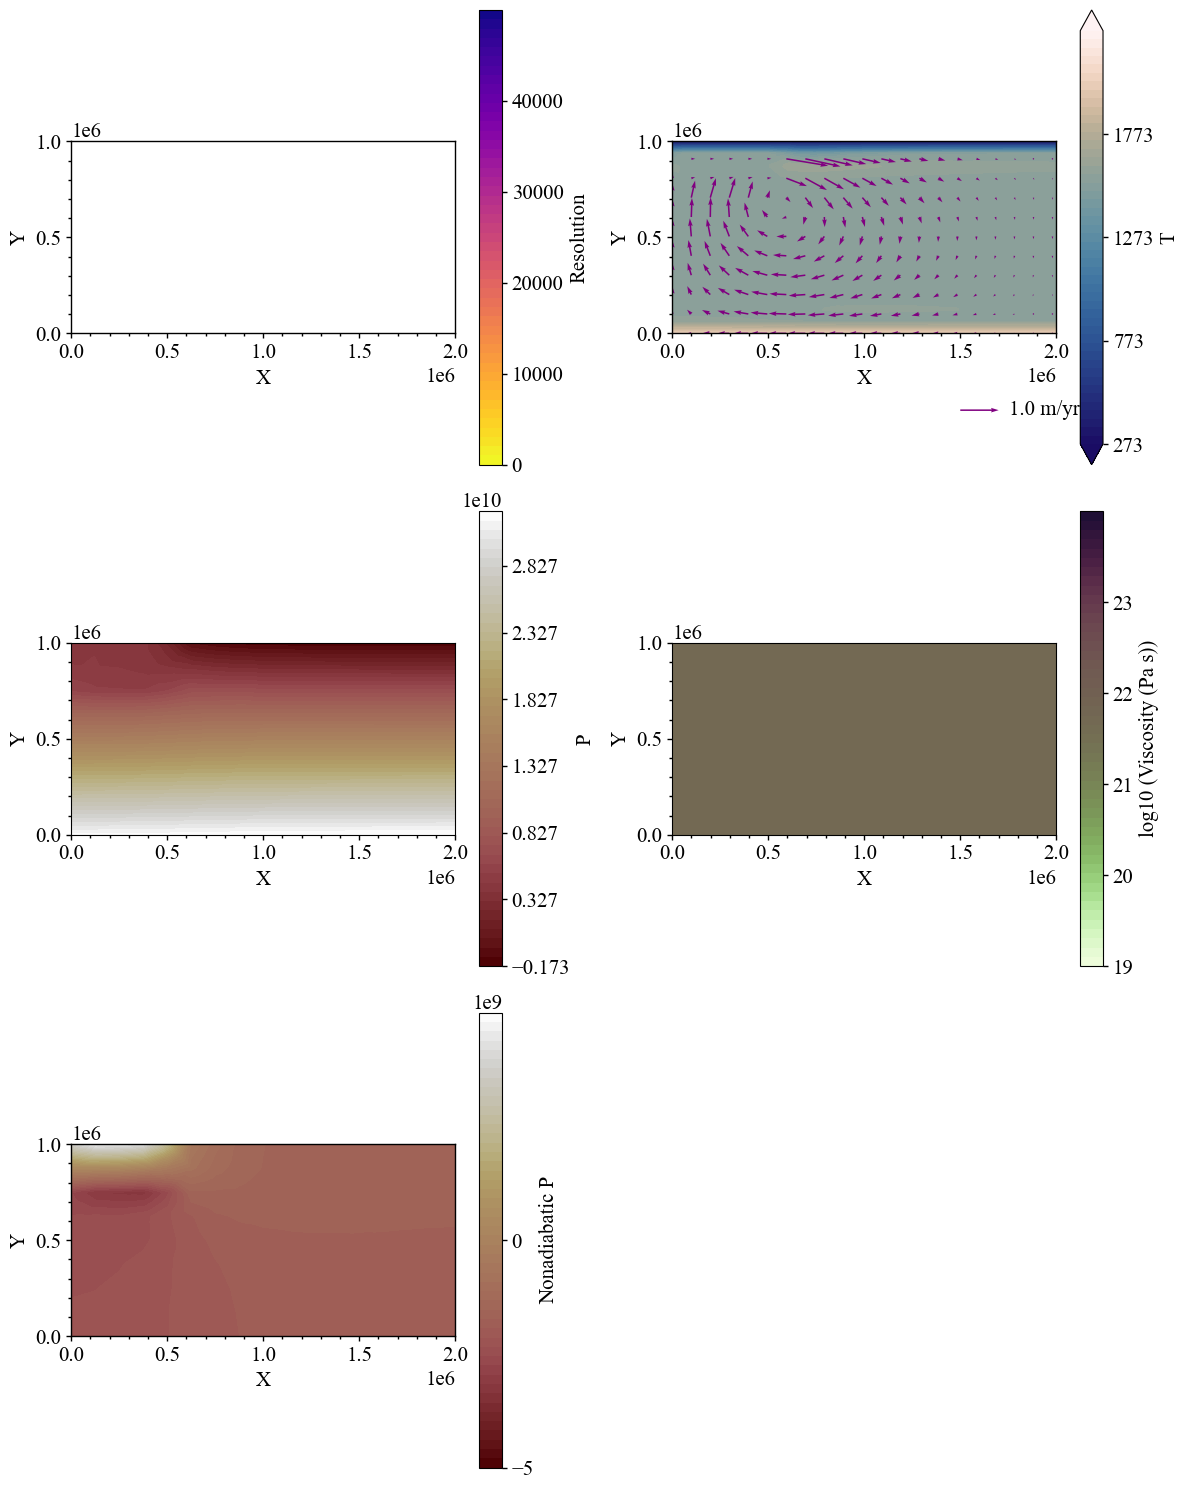

In [6]:
if PR_prescribe_field:
    
    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator
    from matplotlib import gridspec
    from cmcrameri import cm as ccm
    from hamageolib.utils.plot_helper import scale_matplotlib_params

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (0.0, 2e6)
    x_tick_interval = 500e3   # tick interval along x
    y_lim = (0.0, 1e6)
    y_tick_interval = 500e3  # tick interval along y

    resolution_lim = (0.0, 50e3) # resolution
    resolution_level = 50  # number of levels in contourf plot
    resolution_tick_interval = 10e3  # tick interval along v

    T_lim = (273.15, 2273.15) # T
    T_level = 50  # number of levels in contourf plot
    T_tick_interval = 500.0  # tick interval along v

    P_lim = (np.min(P_grid), np.max(P_grid)) # P
    P_level = 50  # number of levels in contourf plot
    P_tick_interval = 5e9  # tick interval along v

    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    # Create a figure with a 2x2 grid layout
    fig = plt.figure(figsize=(12, 15), tight_layout=True)
    gs = gridspec.GridSpec(3, 2)

    # Plot the mesh resolution
    ax = fig.add_subplot(gs[0, 0])

    levels = np.linspace(resolution_lim[0], resolution_lim[1], resolution_level)
    ticks=np.arange(resolution_lim[0], resolution_lim[1], resolution_tick_interval)

    color_map = ax.contourf(x_grid, y_grid, resolutions_grid,  vmin=resolution_lim[0], vmax=resolution_lim[1], levels=levels, cmap="plasma_r")  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="Resolution")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


    # Plot T
    ax = fig.add_subplot(gs[0, 1])

    levels = np.linspace(T_lim[0], T_lim[1], T_level)
    ticks=np.arange(T_lim[0], T_lim[1], T_tick_interval)

    color_map = ax.contourf(x_grid, y_grid, T_grid,  vmin=T_lim[0], vmax=T_lim[1], levels=levels, cmap=ccm.lapaz, extend="both")  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="T")  # Add colorbar
    cbar.set_ticks(ticks)

    step = 10  # plot every 5th vector
    v_max = 1.0
    qv = ax.quiver(x_grid[::step, ::step], y_grid[::step, ::step],\
                vx_grid[::step, ::step], vy_grid[::step, ::step],\
                scale=10, width=0.004, color='purple')
    ax.quiverkey(qv, X=0.85, Y=-0.4, U=v_max, label='%.1f m/yr' % v_max, labelpos='E')

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


    # Plot P
    ax = fig.add_subplot(gs[1, 0])

    levels = np.linspace(P_lim[0], P_lim[1], P_level)
    ticks=np.arange(P_lim[0], P_lim[1], P_tick_interval)

    color_map = ax.contourf(x_grid, y_grid, P_grid,  vmin=P_lim[0], vmax=P_lim[1], levels=levels, cmap=ccm.bilbao)  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="P")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # Plot viscosity
    ax = fig.add_subplot(gs[1, 1])

    visc_min = 19.0; visc_max = 24.0
    levels = np.linspace(visc_min, visc_max, 50)
    ticks=np.arange(visc_min, visc_max, 1.0)

    color_map = ax.contourf(x_grid, y_grid, np.log10(viscosity_grid),  vmin=visc_min, vmax=visc_max, levels=levels, cmap=ccm.tokyo_r)  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="log10 (Viscosity (Pa s))")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # Plot non-adiabatic
    ax = fig.add_subplot(gs[2, 0])

    nP_lim = [-5e9, 5e9]
    levels = np.linspace(nP_lim[0], nP_lim[1], P_level)
    ticks=np.arange(nP_lim[0], nP_lim[1], P_tick_interval)

    color_map = ax.contourf(x_grid, y_grid, nP_grid,  vmin=nP_lim[0], vmax=nP_lim[1], levels=levels, cmap=ccm.bilbao)  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="Nonadiabatic P")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    fig_path = os.path.join(img_dir, "prescribe_field_%05d.png" % vtu_step)
    fig.savefig(fig_path)
    print("Saved figure: ", fig_path)

    # Reset rcParams to defaults
    rcdefaults()

# Create Cases

## 2d case

In [7]:
create_group_2d = False

if create_group_2d:

    from hamageolib.research.haoyuan_2d_subduction.legacy_tools import CreateGroup, CASE_TWOD, CASE_OPT_TWOD
    
    base_json_path = os.path.join(HaMaGeoLib_DIR, "hamageolib/research/haoyuan_2d_subduction/legacy_files/reference_TwoD/240221/case_3d_consistent.json")
    base_dir = os.path.join(HaMaGeoLib_DIR, "hamageolib/research/haoyuan_2d_subduction/legacy_files/reference_TwoD/240221")
    slurm_file_path = os.path.join(HaMaGeoLib_DIR, "scripts/slurm/250816/job_hive_high.sh")
    output_dir = os.path.join(local_TwoDSubduction_dir, "EBA_CDPT_3dconsistent_chunk_3")

    group_json_2d = \
    {
        "base name": "eba_cdpt_coh300", 
        "base json": base_json_path,
        "base directory": base_dir,
        "output directory": output_dir,
        "slurm base file": slurm_file_path,
        "combine case run": 1,
      "base features":[
            {
                "name": "Value of Coh to use in the rheology",
                "key": ["mantle rheology", "Coh"],
                "unit": "",
                "values": [300.0],
                "abbreviating strings": [""]
            },
            {
                "name": "Viscosity in the slab core",
                "key": ["shear zone", "slab core viscosity"],
                "unit": "pa s",
                "values": [1e22],
                "abbreviating strings": [""]
            },
            {
                "name": "Include peierls creep",
                "key": ["include peierls creep"],
                "unit": "",
                "values": [1],
                "abbreviating strings": [""]
            },
            {
                "name": "Geometry",
                "key": ["geometry"],
                "unit": "",
                "values": ["chunk"],
                "abbreviating strings": [""]
            },
            {
                "name": "Thickness of the shear zone / crust",
                "key": ["shear zone", "thickness"],
                "unit": "m",
                "values": [15e3],
                "abbreviating strings": [""]
            },
            {
                "name": "Height of the box",
                "key": ["world builder", "box height"],
                "unit": "km",
                "values": [2890e3],
                "abbreviating strings": [""]
            }
        ],
        "features":[
            {
                "name": "Age of the subducting plate",
                "key": ["world builder", "subducting plate", "age trench"],
                "unit": "yr",
                "values": [40e6, 50e6, 80e6, 150e6],
                "abbreviation by value": 1,
                "abbreviating value options": ["SA", 1e-6]
            },
            {
                "name": "Age of the overiding plate",
                "key": ["world builder", "overiding plate", "age"],
                "unit": "yr",
                "values": [20e6, 40e6],
                "abbreviation by value": 1,
                "abbreviating value options": ["OA", 1e-6]
            },
            {
                "name": "Width of the box",
                "key": ["world builder", "box width before adjusting"],
                "unit": "km",
                "values": [5.6709e6, 6.783e6, 8.896e6, 1.557e7],
                "abbreviating strings": ["width51", "width61", "width80", "width140"],
                "if abbreviating": [1, 1, 1, 1]
            },
            {
                "name": "Slab strength",
                "key": ["slab", "strength"],
                "unit": "pa",
                "values": [100e6, 300e6, 500e6, 1e12],
                "abbreviation by value": 1,
                "abbreviating value options": ["ss", 1e-6]
            },
            {
                "name": "Trench migration",
                "key": ["world builder", "trench migration"],
                "unit": "m",
                "values":[0.0, -500e3, -1000e3, -1500e3],
                "abbreviating strings": ["", "lwidth4.5", "lwidth9", "lwidth13.5"],
                "if abbreviating": [0, 1, 1, 1]
            }
        ],
        "bindings": [[1, 0, 2, 3, 0], [1, 0, 2, 3, 2]],
        "slurm": [
          {
            "slurm file": slurm_file_path,
            "build directory": "master_TwoD",
            "tasks per node": 8,
            "cpus": 8
          }
      ]
    }



In [8]:
if create_group_2d:
    CreateGroup(group_json_2d, CASE_TWOD, CASE_OPT_TWOD)

## 3d case

In [9]:
create_group = False

if create_group:

    from hamageolib.research.haoyuan_2d_subduction.legacy_tools import CreateGroup, CASE_THD, CASE_OPT_THD

    base_json_path = os.path.join(HaMaGeoLib_DIR, "hamageolib/research/haoyuan_2d_subduction/legacy_files/reference_ThD/08112025/case_2d_consistent.json")
    base_dir = os.path.join(HaMaGeoLib_DIR, "hamageolib/research/haoyuan_2d_subduction/legacy_files/reference_ThD/08112025")
    slurm_file_path = os.path.join(HaMaGeoLib_DIR, "scripts/slurm/250816/job_frontera-normal.sh")
    output_dir = "/mnt/lochy/ASPECT_DATA/ThDSubduction/EBA_2d_consistent_11"
    branch = "master_TwoD_dealii-9.4.0_07212025"


    if create_group:
        group_json = \
        {
          "base name": "eba3d_1",
          "type": "2d_consistent", 
          "base json": base_json_path,
          "base directory": base_dir,
          "output directory": output_dir,
          "branch": branch,
          "base features":[
          {
                    "name": "Geometry",
                    "key": ["geometry"],
                    "unit": "",
                    "values": ["box"],
                    "abbreviating strings": [""]
          },
          {
                    "name": "Viscosity in the slab core",
                    "key": ["shear zone", "slab core viscosity"],
                    "unit": "Pa s",
                    "values": [1e22],
                    "abbreviating strings": [""]
          },
          {
                    "name": "Output non-adiabatic pressure",
                    "key": ["post-process", "nonadiabatic pressure"],
                    "unit": "",
                    "values": [1],
                    "abbreviating strings": [""]
          },
          {
              "name": "Slab strengh",
              "key": ["plate setup", "strength"],
              "unit": "Pa",
              "values": [1e12],
              "abbreviating strings": [""]
          }
          ],
          "features":[
          {
                  "name": "Age of the subducting plate at trench",
                  "key": ["plate setup", "sp age"],
                  "unit": "yr",
                  "values": [50e6, 80e6],
                  "abbreviation by value": 1,
                  "abbreviating value options": ["SA", 1e-6],
                  "if abbreviating": [1, 1]
          },
          {
                  "name": "Age of the overiding plate",
                  "key": ["plate setup", "ov age"],
                  "unit": "yr",
                  "values": [20e6, 40e6],
                  "abbreviation by value": 1,
                  "abbreviating value options": ["OA", 1e-6],
                  "if abbreviating": [1, 1]
          },
          {
                  "name": "Length of the Box before adjusting for the age of the trench.",
                  "key": ["geometry setup", "box length before adjusting"],
                  "unit": "m",
                  "values": [6.783e6, 8.896e6, 1.557e7, 5.671e6],
                  "abbreviating strings": ["width61", "width80", "width140", "width51"],
                  "if abbreviating": [1, 1, 1, 1]
          },
          {
                  "name": "Width of the box",
                  "key": ["geometry setup", "box width"],
                  "unit": "m",
                  "values": [2000e3, 4000e3, 8000e3],
                  "abbreviating strings": ["bw2000", "bw4000", "bw8000"],
                  "if abbreviating": [1, 1, 1]
              
          },
          {
                  "name": "Width of the subducting plate",
                  "key": ["plate setup", "sp width"],
                  "unit": "m",
                  "values": [500e3, 1000e3, 2000e3],
                  "abbreviating strings": ["sw500", "sw1000", "sw2000"],
                  "if abbreviating": [1, 1, 1]
          }
          ],
          "bindings": [[0, 0, 1, 1, 1], [0, 0, 1, 2, 2], [0, 0, 1, 0, 0]],
          "slurm":[
          {
            "slurm file": slurm_file_path,
            "build directory": branch,
            "tasks per node": 56,
            "cpus": 1120
          }
          ]
        }


"""
other options
          {
              "name": "Slab strengh",
              "key": ["plate setup", "strength"],
              "unit": "1",
              "values": [100e6, 300e6, 500e6, 1e12],
              "abbreviation by value": 1,
              "abbreviating value options": ["yd", 1e-6]
          },
          {
              "name": "Adaptive refinement",
              "key": ["refinement", "adaptive refinement"],
              "unit": "1",
              "values": [4, 5, 3],
              "abbreviation by value": 1,
              "abbreviating value options": ["AR", 1.0]
          }
         {
                  "name": "Trench migration",
                  "key": ['plate setup', "trench migration"],
                  "unit": "m",
                  "values": [0.0, -1000e3, -1500e3],
                  "abbreviating strings": ["", "lwidth9", "lwidth13.5"],
                  "if abbreviating": [0, 1, 1]
          }
"""

'\nother options\n          {\n              "name": "Slab strengh",\n              "key": ["plate setup", "strength"],\n              "unit": "1",\n              "values": [100e6, 300e6, 500e6, 1e12],\n              "abbreviation by value": 1,\n              "abbreviating value options": ["yd", 1e-6]\n          },\n          {\n              "name": "Adaptive refinement",\n              "key": ["refinement", "adaptive refinement"],\n              "unit": "1",\n              "values": [4, 5, 3],\n              "abbreviation by value": 1,\n              "abbreviating value options": ["AR", 1.0]\n          }\n         {\n                  "name": "Trench migration",\n                  "key": [\'plate setup\', "trench migration"],\n                  "unit": "m",\n                  "values": [0.0, -1000e3, -1500e3],\n                  "abbreviating strings": ["", "lwidth9", "lwidth13.5"],\n                  "if abbreviating": [0, 1, 1]\n          }\n'

In [10]:
if create_group:
    CreateGroup(group_json, CASE_THD, CASE_OPT_THD)

# Post-process

In [ ]:
do_postprocess = True

# Case name

case_name is the relative path to local_TwoDSubduction_dir, and local_ThDSubduction_dir

In [11]:
# Cases without a Peierls creep
# case_name = None; case_name_2d = "EBA_CDPT_3dconsistent_9/eba_cdpt_coh300_SA80.0_OA40.0_width80_sc22"

# Cases with the Peierls creep, a deep box
# case_name = "EBA_2d_consistent_8_6/eba3d_width51_c22_AR4"; case_name_2d = "EBA_CDPT_3dconsistent_9/eba_cdpt_coh300_SA80.0_OA40.0_width51_sc22"
# case_name = "EBA_2d_consistent_8_6/eba3d_width61_c22_AR4"; case_name_2d = "EBA_CDPT_3dconsistent_9/eba_cdpt_coh300_SA80.0_OA40.0_width61_sc22"
# case_name = "EBA_2d_consistent_8_6/eba3d_width61_c22_AR3"
# case_name = "EBA_2d_consistent_8_6/eba3d_width61_c23_AR4"
# case_name = "EBA_2d_consistent_8_6/eba3d_width80_c22_AR4"; case_name_2d = "EBA_CDPT_3dconsistent_9/eba_cdpt_coh300_SA80.0_OA40.0_width80_sc22"
# case_name ="EBA_2d_consistent_8_6/eba3d_width61_c22_AR5"
# case_name = "EBA_2d_consistent_8_8/eba3d_width80_bw8000_sw2000_c22_AR4_yd300.0"; case_name_2d = "EBA_CDPT_3dconsistent_13/eba_cdpt_coh300_SA80.0_OA40.0_width80_ss300.0"
# case_name = None; case_name_2d = "EBA_CDPT_3dconsistent_9/eba_cdpt_coh300_SA80.0_OA40.0_width80_sc22_nlht"
# case_name = None; case_name_2d = "EBA_CDPT_3dconsistent_10/eba_cdpt_coh300_SA80.0_OA40.0_width80_sc22_ss100.0"
# case_name = "EBA_2d_consistent_8_6/eba3d_width140_c22_AR4"
# case_name = "EBA_2d_consistent_9/eba3d_width80_h2000"
# case_name = "EBA_2d_consistent_8_7/eba3d_width80_bw2000_sw500_c22_AR4" ; 
# case_name = "EBA_2d_consistent_8_7/eba3d_width80_bw8000_sw2000_c22_AR4"; case_name_2d = "EBA_CDPT_3dconsistent_9/eba_cdpt_coh300_SA80.0_OA40.0_width80_sc22"
# case_name = "EBA_2d_consistent_8_8/eba3d_width51_bw4000_sw1000_c22_AR4_yd300.0"; case_name_2d = "EBA_CDPT_3dconsistent_10/eba_cdpt_coh300_SA80.0_OA40.0_width51_sc22_ss300.0"
# case_name = "EBA_2d_consistent_8_8/eba3d_width80_bw2000_sw500_c22_AR4_yd300.0"; 

# Cases with 50 Ma Sp plate
# case_name = None; case_name_2d = "EBA_CDPT_3dconsistent_14/eba_cdpt_coh300_SA50.0_OA20.0_width80_ss500.0"
# case_name = None; case_name_2d = "EBA_CDPT_3dconsistent_chunk_3/eba_cdpt_coh300_SA50.0_OA20.0_width80_ss1000000.0_lwidth9"
case_name = "EBA_2d_consistent_11/eba3d_1_SA50.0_OA20.0_width80_bw8000_sw2000"; case_name_2d = None

# Cases with the Peierls creep, a shallow box
# case_name = None; case_name_2d = "EBA_CDPT_3dconsistent_12/eba_cdpt_coh300_SA40.0_OA20.0_width80_h1000_ss300.0"
# case_name = None; case_name_2d = "EBA_CDPT_3dconsistent_12/eba_cdpt_coh300_SA80.0_OA40.0_width80_h1000_ss300.0"
# case_name = "EBA_2d_consistent_8_6/eba3d_width80_c22_AR4_yd100"; case_name_2d = "EBA_CDPT_3dconsistent_13/eba_cdpt_coh300_SA80.0_OA40.0_width80_ss100.0"
# case_name = "EBA_2d_consistent_8_6/eba3d_width80_c22_AR4_yd300"; case_name_2d = "EBA_CDPT_3dconsistent_13/eba_cdpt_coh300_SA80.0_OA40.0_width80_ss300.0"
# case_name = "EBA_2d_consistent_9/eba3d_width80_h1000"; case_name_2d = "EBA_CDPT_3dconsistent_13/eba_cdpt_coh300_SA80.0_OA40.0_width80_h1000_ss1000000.0"
# case_name = "EBA_2d_consistent_9/eba3d_width80_h2000"; case_name_2d = None

# case_name = "chunk_test/chunk_initial0"
# case_name = "chunk_test/chunk_initial1"
# case_name = "chunk_test/chunk_initial2"
# case_name = "chunk_test/chunk_initial3"
# case_name = "chunk_test/chunk_initial4"
# case_name = "chunk_test/chunk_initial5"
# case_name = "chunk_test/chunk_initial6"
# case_name = "chunk_test/chunk_initial7"
# case_name = "chunk_test/chunk_initial8"
# case_name = "chunk_test/chunk_initial8_T"
# case_name = "chunk_test/chunk_initial9"; case_name_2d = "EBA_CDPT_3dconsistent_chunk_1/eba_cdpt_coh300_SA80.0_OA40.0_width61_ss1000000.0"
# case_name = "chunk_test/chunk_initial9_re_test_1"; case_name_2d = "EBA_CDPT_3dconsistent_chunk_1/eba_cdpt_coh300_SA80.0_OA40.0_width61_ss1000000.0"
# case_name = None; case_name_2d = "EBA_CDPT_3dconsistent_chunk_1/eba_cdpt_coh300_SA80.0_OA40.0_width51_ss1000000.0"
# case_name = None; case_name_2d = "EBA_CDPT_3dconsistent_chunk_1/eba_cdpt_coh300_SA80.0_OA40.0_width80_ss1000000.0"
# case_name = None; case_name_2d = "EBA_CDPT_3dconsistent_chunk_1/eba_cdpt_coh300_SA80.0_OA40.0_width140_ss1000000.0"
# case_name = None; case_name_2d = "EBA_CDPT_3dconsistent_chunk_1/eba_cdpt_coh300_SA40.0_OA20.0_width80_ss1000000.0"
# case_name = "chunk_test/chunk_initial9_re_test"
# case_name = "chunk_geometry1/eba3d_width80_bw4000_sw1000_yd500.0_AR4"; case_name_2d = "EBA_CDPT_3dconsistent_chunk_1/eba_cdpt_coh300_SA80.0_OA40.0_width80_ss500.0"
# case_name = "chunk_geometry1/eba3d_width80_bw4000_sw1000_yd100.0_AR4"; case_name_2d = "EBA_CDPT_3dconsistent_chunk_1/eba_cdpt_coh300_SA80.0_OA40.0_width80_ss100.0"
# case_name = "chunk_geometry1/eba3d_width80_bw8000_sw2000_yd500.0_AR4"; case_name_2d = "EBA_CDPT_3dconsistent_chunk_1/eba_cdpt_coh300_SA80.0_OA40.0_width80_ss500.0"



# Cases with 50 Ma Sp plate, spherical
# case_name = "chunk_geometry2/eba3d_1_SA50.0_OA20.0_width80_bw4000_sw1000_yd500.0_AR4"; case_name_2d = "EBA_CDPT_3dconsistent_chunk_2/eba_cdpt_coh300_SA50.0_OA20.0_width80_ss500.0"
# case_name = "chunk_geometry2/eba3d_SA50.0_OA20.0_width80_bw4000_sw1000_yd500.0_AR4"; case_name_2d = "EBA_CDPT_3dconsistent_chunk_2/eba_cdpt_coh300_SA50.0_OA20.0_width80_ss1000000.0"
# case_name = "chunk_geometry3/eba3d_1_SA50.0_OA20.0_width80_bw4000_sw1000"; case_name_2d = None
# wider box
# case_name = "chunk_geometry3/eba3d_1_SA50.0_OA20.0_width80_bw8000_sw2000"; case_name_2d = "EBA_CDPT_3dconsistent_chunk_2/eba_cdpt_coh300_SA50.0_OA20.0_width80_ss1000000.0"
# shorter box
# case_name = "chunk_geometry3/eba3d_1_SA50.0_OA20.0_width51_bw4000_sw1000"; case_name_2d = "EBA_CDPT_3dconsistent_chunk_2/eba_cdpt_coh300_SA50.0_OA20.0_width51_ss1000000.0"
# case_name = None; case_name_2d = "EBA_CDPT_3dconsistent_chunk_2/eba_cdpt_coh300_SA50.0_OA20.0_width61_ss1000000.0"
# smaller distance to left side
# case_name = "chunk_geometry3/eba3d_1_SA50.0_OA20.0_width80_bw4000_sw1000_lwidth9"; case_name_2d = "EBA_CDPT_3dconsistent_chunk_3/eba_cdpt_coh300_SA50.0_OA20.0_width80_ss1000000.0_lwidth9"
# case_name = "chunk_geometry3/eba3d_1_SA50.0_OA20.0_width80_bw4000_sw1000_lwidth13.5"; case_name_2d = None


local_dir = None; local_dir_2d = None
if case_name is not None:
    local_dir = os.path.join(local_ThDSubduction_dir, case_name)
    assert(os.path.isdir(local_dir))
    print("local_dir:\n\t", local_dir)
    subprocess.run(['mkdir', '-p', '%s/img/pv_outputs' % local_dir])
if case_name_2d is not None:
    local_dir_2d = os.path.join(local_TwoDSubduction_dir, case_name_2d)
    assert(os.path.isdir(local_dir_2d))
    print("local_dir_2d:\n\t", local_dir_2d)
    subprocess.run(['mkdir', '-p', '%s/img/pv_outputs' % local_dir_2d])

local_dir:
	 /mnt/lochy/ASPECT_DATA/ThDSubduction/EBA_2d_consistent_11/eba3d_1_SA50.0_OA20.0_width80_bw8000_sw2000


# Visualization

The next block will generate plots of runtime, solver statistics, etc., and will compose a script to run in ParaView.

## 3d case

- Processing vtu data with pyvista
- Generate paraview scritps

### Generate Paraview script

In [12]:
is_prepare_for_plot = True
is_process_pyvista_for_plot = True

if is_prepare_for_plot:

    from hamageolib.research.haoyuan_3d_subduction.post_process import get_trench_position_from_file, get_slab_depth_from_file,\
          PLOT_CASE_RUN_THD, ProcessVtuFileThDStep
    from hamageolib.research.haoyuan_3d_subduction.case_options import CASE_OPTIONS
    
    assert(local_dir is not None)

    # options 
    graphical_step = 99
    n_pieces = None # process the whole dataset together
    # n_pieces = 16  # process the dataset piecewise

    # processing options
    do_clip = False
    extract_trench_at_additional_depths = [50e3]


    # parameters
    ofile_list = ["slab1.py"]; require_base=True
    time_range = None
    time_interval = None
    # turn on plot_axis if I want to save a complete result
    # turn off if I want to prepare for figures in a paper
    plot_axis = False
    slices=None # specify steps
    # step = "auto"; slices=3  # auto-figure out the steps, take the numebr of slices
    max_velocity = -1.0  # rescale the color for velocity
    rotation_plus = 0.47 # rotation of the frame along the lon when making plot

    # case options 
    Case_Options = CASE_OPTIONS(local_dir)
    Case_Options.Interpret()
    Case_Options.SummaryCaseVtuStep(os.path.join(local_dir, "summary.csv"))

    # Initiate plotting class
    PlotCaseRunThD = PLOT_CASE_RUN_THD(local_dir, time_range=time_range, run_visual=False,\
            time_interval=time_interval, visualization="paraview", step=graphical_step, plot_axis=plot_axis, max_velocity=max_velocity,\
                    rotation_plus=rotation_plus, ofile_list=ofile_list, require_base=require_base)

    # Processing pyvista
    if is_process_pyvista_for_plot:
        pvtu_step = graphical_step + int(Case_Options.options['INITIAL_ADAPTIVE_REFINEMENT'])
        _, outputs = ProcessVtuFileThDStep(local_dir, pvtu_step, Case_Options, do_clip=do_clip, extract_trench_at_additional_depths=extract_trench_at_additional_depths,\
                              n_pieces=n_pieces)

    # get initial trench position    
    pyvista_outdir0 = os.path.join(local_dir, "pyvista_outputs", "%05d" % int(Case_Options.options['INITIAL_ADAPTIVE_REFINEMENT']))
    try:
        trench_center_ini = get_trench_position_from_file(pyvista_outdir0, int(Case_Options.options['INITIAL_ADAPTIVE_REFINEMENT']), Case_Options.options['GEOMETRY'])
    except FileNotFoundError:
        trench_center_ini = -1.0

    # Generate paraview script
    # Get time 
    idx = Case_Options.summary_df["Vtu step"] == graphical_step
    _time = Case_Options.summary_df.loc[idx, "Time"].values[0]
    # get trench center
    pvtu_step = graphical_step + int(Case_Options.options['INITIAL_ADAPTIVE_REFINEMENT']) 
    pyvista_outdir = os.path.join(local_dir, "pyvista_outputs", "%05d" % pvtu_step)
    trench_center = get_trench_position_from_file(pyvista_outdir, pvtu_step, Case_Options.options['GEOMETRY'])
    slab_depth = get_slab_depth_from_file(pyvista_outdir, pvtu_step, Case_Options.options['GEOMETRY'], float(Case_Options.options['OUTER_RADIUS']), "sp_lower")
    # generate paraview script
    addtional_options = {"TRENCH_CENTER": trench_center, "TRENCH_INI_DERIVED": trench_center_ini, "PLOT_TIME": _time}
    PlotCaseRunThD.GenerateParaviewScript(ofile_list, addtional_options)

FileNotFoundError: BASH_OPTIONS.__init__: case output directory - /mnt/lochy/ASPECT_DATA/ThDSubduction/EBA_2d_consistent_11/eba3d_1_SA50.0_OA20.0_width80_bw8000_sw2000/output doesn't exist

### Automazed workflow to finalize visualization

In [ ]:
finalize_visual = False

if finalize_visual:

    from IPython.display import Image, display
    from hamageolib.research.haoyuan_2d_subduction.workflow_scripts import finalize_visualization_2d_12172024
    from hamageolib.research.haoyuan_3d_subduction.post_process import finalize_visualization_2d_07222025_box

    _time = 1.8502e+07
    
    # file types
    file_name = "slice_center_viscosity"

    if file_name in ["slice_center_viscosity", "T", "density", "metastable"]:

        if Case_Options.options["GEOMETRY"] == "chunk": 
            frame_png_file_with_ticks = "/home/lochy/Documents/papers/documented_files/ThDSubduction/Frame/upper_mantle_frame_12172024_trans_modified-01.png"
            output_image_file = finalize_visualization_2d_12172024(local_dir, file_name, _time, frame_png_file_with_ticks, add_time=False)
        else:
            frame_png_file_with_ticks = "/home/lochy/Documents/papers/documented_files/ThDSubduction/Frame/upper_mantle_frame_07222025_trans_modified_box-01.png"
            output_image_file = finalize_visualization_2d_07222025_box(local_dir, file_name, _time, frame_png_file_with_ticks, add_time=False)

### Analyze Slab Morphology

A separate script is generated to analyze slab morphology for all time steps.
Here the code block serves to analyze a single block.

In [ ]:
is_slab_morphology = False
is_process_pyvista_for_slab_morphology = False

if is_slab_morphology:

    # Initiate the case option class
    from hamageolib.research.haoyuan_3d_subduction.post_process import get_trench_position_from_file, get_slab_depth_from_file, PLOT_CASE_RUN_THD
    from hamageolib.research.haoyuan_3d_subduction.case_options import CASE_OPTIONS

    time_range = None
    time_interval = None
    # turn on plot_axis if I want to save a complete result
    # turn off if I want to prepare for figures in a paper
    plot_axis = False
    slices=None # specify steps
    # step = "auto"; slices=3  # auto-figure out the steps, take the numebr of slices
    max_velocity = -1.0  # rescale the color for velocity
    rotation_plus = 0.47 # rotation of the frame along the lon when making plot

    Case_Options = CASE_OPTIONS(local_dir)
    Case_Options.Interpret()
    Case_Options.SummaryCaseVtuStep(os.path.join(local_dir, "summary.csv"))

    graphical_steps_np = Case_Options.summary_df["Vtu step"].to_numpy()
    graphical_steps = [int(step) for step in graphical_steps_np]

    # Initiate plotting class
    PlotCaseRunThD = PLOT_CASE_RUN_THD(local_dir, time_range=time_range, run_visual=False,\
            time_interval=time_interval, visualization="paraview", step=graphical_steps, plot_axis=plot_axis, max_velocity=max_velocity,\
                    rotation_plus=rotation_plus, ofile_list=None, require_base=True)

    # Processing pyvista
    if is_process_pyvista_for_slab_morphology:
        PlotCaseRunThD.ProcessPyvista()

    # Generate paraview script
    for step in graphical_steps:
        # get trench center
        pvtu_step = step + int(Case_Options.options['INITIAL_ADAPTIVE_REFINEMENT']) 
        pyvista_outdir = os.path.join(local_dir, "pyvista_outputs", "%05d" % pvtu_step)
        trench_center = get_trench_position_from_file(pyvista_outdir, pvtu_step, Case_Options.options['GEOMETRY'])
        slab_depth = get_slab_depth_from_file(pyvista_outdir, pvtu_step, Case_Options.options['GEOMETRY'], float(Case_Options.options['OUTER_RADIUS']), "sp_lower")
        # generate paraview script
        addtional_options = {"TRENCH_CENTER": trench_center}
        PlotCaseRunThD.GenerateParaviewScript(ofile_list, addtional_options)
        # update value in sumamry
        Case_Options.SummaryCaseVtuStepUpdateValue("Slab depth", step, slab_depth)
        Case_Options.SummaryCaseVtuStepUpdateValue("Trench (center)", step, trench_center)

        break # debug

    Case_Options.SummaryCaseVtuStepExport(os.path.join(local_dir, "summary.csv"))

## 2d case

### Generate Paraview script

Before this step, first run the SlabMorphology\_2d.py to generate results for all the vtu-steps

In [ ]:
# plot the 2d case: prepare data and paraview script
is_prepare_for_plot_2d = True
is_process_pyvista_for_plot_2d = True

if is_prepare_for_plot_2d:
    from hamageolib.research.haoyuan_3d_subduction.case_options import CASE_OPTIONS_TWOD1
    from hamageolib.research.haoyuan_3d_subduction.post_process import PlotCaseRunTwoD1, ProcessVtuFileTwoDStep
    from hamageolib.research.haoyuan_2d_subduction.workflow_scripts import run_2d_subduction_visualization

    assert(local_dir_2d is not None)

    # parameters
    graphical_step = 162 # specify steps
    rotation_plus = 0.47 # rotation of the frame along the lon when making plot

    # case options 
    Case_Options_2d = CASE_OPTIONS_TWOD1(local_dir_2d)
    Case_Options_2d.Interpret()
    Case_Options_2d.SummaryCaseVtuStep(os.path.join(local_dir_2d, "summary.csv"))

    # Processing pyvista
    if is_process_pyvista_for_plot_2d:
        pvtu_step = graphical_step + int(Case_Options_2d.options['INITIAL_ADAPTIVE_REFINEMENT'])
        output_dict = ProcessVtuFileTwoDStep(local_dir_2d, pvtu_step, Case_Options_2d)
        Case_Options_2d.SummaryCaseVtuStepUpdateValue("Slab depth", graphical_step, output_dict["slab_depth"])
        Case_Options_2d.SummaryCaseVtuStepUpdateValue("Trench", graphical_step, output_dict["trench_center"])

    # Generate paraview script
    # Get time 
    idx = Case_Options_2d.summary_df["Vtu step"] == graphical_step
    _time = Case_Options_2d.summary_df.loc[idx, "Time"].values[0]
    pvtu_step = graphical_step + int(Case_Options_2d.options['INITIAL_ADAPTIVE_REFINEMENT']) 
    pyvista_outdir = os.path.join(local_dir_2d, "pyvista_outputs", "%05d" % pvtu_step)
    # Get trench center
    trench_initial = Case_Options_2d.summary_df.loc[0, "Trench"]
    trench_center = Case_Options_2d.summary_df.loc[idx, "Trench"].values[0]
    # Initiate plotting class
    additional_options = {"TRENCH_CENTER": trench_center, "TRENCH_INI_DERIVED": trench_initial}
    PlotCaseRunTwoD1(local_dir_2d, step=graphical_step, rotation_plus=rotation_plus, additional_options=additional_options)

### Automazed workflow to finalize visualization

In [ ]:
finalize_visual_2d = False

if finalize_visual_2d:

    from IPython.display import Image, display
    from hamageolib.research.haoyuan_2d_subduction.workflow_scripts import finalize_visualization_2d_12172024
    from hamageolib.research.haoyuan_3d_subduction.post_process import finalize_visualization_2d_07222025_box

    _time = 1.6200e+07
    
    # file types
    file_name = "slice_center_viscosity"

    if file_name in ["slice_center_viscosity", "T", "density", "metastable"]:
        if Case_Options_2d.options["GEOMETRY"] == "chunk":
            frame_png_file_with_ticks = "/home/lochy/Documents/papers/documented_files/ThDSubduction/Frame/upper_mantle_frame_12172024_trans_modified-01.png"
            output_image_file = finalize_visualization_2d_12172024(local_dir_2d, file_name, _time, frame_png_file_with_ticks, add_time=False)
        else:
            frame_png_file_with_ticks = "/home/lochy/Documents/papers/documented_files/ThDSubduction/Frame/upper_mantle_frame_07222025_trans_modified_box-01.png"
            output_image_file = finalize_visualization_2d_07222025_box(local_dir_2d, file_name, _time, frame_png_file_with_ticks, add_time=False)

# Combine plots

## Slab morphology

In [ ]:
is_plot_slab_morphology = True

if is_plot_slab_morphology:

    from hamageolib.research.haoyuan_3d_subduction.post_process import PlotSlabMorphology
    from hamageolib.research.haoyuan_3d_subduction.case_options import CASE_OPTIONS, CASE_OPTIONS_TWOD1

    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    from matplotlib.ticker import MultipleLocator 
    from matplotlib import rcdefaults
    from matplotlib.patches import Patch

    import hamageolib.utils.plot_helper as plot_helper

    local_dir_list = [os.path.join(local_ThDSubduction_dir, "chunk_geometry3/eba3d_1_SA50.0_OA20.0_width80_bw4000_sw1000"), local_dir] 
    local_dir_2d_list = [os.path.join(local_TwoDSubduction_dir, "EBA_CDPT_3dconsistent_chunk_2/eba_cdpt_coh300_SA50.0_OA20.0_width80_ss1000000.0"), local_dir_2d] 
    # os.path.join(local_TwoDSubduction_dir, "foo")
    # os.path.join(local_ThDSubduction_dir, "foo")

    time_marker = None
    factor_3d = 10
    factor_2d = 5
    odir = os.path.join(local_dir, "img")
    
    if not os.path.isdir(odir):
        os.mkdir(odir)
    
    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot, 3.0 for combine with visualization
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    t_lim = (0.0, 30.0)
    t_tick_interval = 5.0   # tick interval along x
    y_lim = (-5.0, 5.0)
    y_tick_interval = 100.0  # tick interval along y
    v_lim = (-1.5, 1.5)
    v_level = 50  # number of levels in contourf plot
    v_tick_interval = 0.5  # tick interval along v
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    # Initiate figure
    fig = plt.figure(figsize=(10*scaling_factor, 3.5*scaling_factor), tight_layout=True)
    gs = gridspec.GridSpec(1, 2)



    # add axis
    ax = fig.add_subplot(gs[0, 0])
    ax_twin = ax.twinx()
    ax1 = fig.add_subplot(gs[0, 1])
    ax1_twinx = ax1.twinx()

    for i, _dir in enumerate(local_dir_list):
        # get 3d data and plot
        # Initiate case options
        Case_Options = CASE_OPTIONS(_dir)

        Case_Options.Interpret()
        geometry = Case_Options.options["GEOMETRY"]
        Ro = Case_Options.options["OUTER_RADIUS"]

        Case_Options.SummaryCaseVtuStep(os.path.join(_dir, "summary.csv"))

        time_3d = Case_Options.summary_df["Time"].to_numpy()
        trench_center_3d = Case_Options.summary_df["Trench (center)"].to_numpy()
        slab_depth_3d = Case_Options.summary_df["Slab depth"].to_numpy()
        dip_angle_center_3d = Case_Options.summary_df["Dip 100 (center)"].to_numpy()
        if geometry == "chunk":
            trench_center_3d *= Ro
        Xs_3d = time_3d/1e6
        Ys_3d = (trench_center_3d - trench_center_3d[0])/1e3
        Ys_3d_1 = slab_depth_3d/1e3
        dx_dy_3d = np.gradient(Ys_3d[::factor_3d], Xs_3d[::factor_3d]) / 1e3 * 1e2
        dx_dy_3d_1 = np.gradient(Ys_3d_1[::factor_3d], Xs_3d[::factor_3d]) / 1e3 * 1e2
        ax.plot(Xs_3d[::factor_3d],  Ys_3d[::factor_3d], label="Trench (center)", color=default_colors[2*i])
        ax_twin.plot(Xs_3d[::factor_3d],  Ys_3d_1[::factor_3d], linestyle="-.", label="Slab Depth", color=default_colors[2*i])

        ax1.plot(Xs_3d[::factor_3d], dx_dy_3d, label="Trench Velocity (center)", color=default_colors[2*i])
        ax1.plot(Xs_3d[::factor_3d], dx_dy_3d_1, linestyle="-.", label="Sinking Velocity (center)", color=default_colors[2*i])

        ax1_twinx.plot(Xs_3d[::factor_3d], dip_angle_center_3d[::factor_3d]*180.0/np.pi, label="Dip 100 (center)", linestyle="--", color=default_colors[2*i])
        

    # get 2d data and plot
    for i, dir_2d in enumerate(local_dir_2d_list):
        if dir_2d is not None:
            assert(isinstance(dir_2d, str) and os.path.isdir(dir_2d))
            Case_Options_2d = CASE_OPTIONS_TWOD1(dir_2d)
            Case_Options_2d.Interpret()
            Case_Options_2d.SummaryCaseVtuStep(os.path.join(dir_2d, "summary.csv"))

            time_2d = Case_Options_2d.summary_df["Time"].to_numpy()
            trench_center_2d = Case_Options_2d.summary_df["Trench"].to_numpy()
            slab_depth_2d = Case_Options_2d.summary_df["Slab depth"].to_numpy()
            dip_angle_2d = Case_Options_2d.summary_df["Dip 100"].to_numpy()
            if geometry == "chunk":
                trench_center_2d *= Ro

            Xs_2d = time_2d/1e6
            Ys_2d = (trench_center_2d - trench_center_2d[0])/1e3
            Ys_2d_1 = slab_depth_2d/1e3
            dx_dy_2d = np.gradient(Ys_2d[::factor_2d], Xs_2d[::factor_2d]) / 1e3 * 1e2
            dx_dy_2d_1 = np.gradient(Ys_2d_1[::factor_2d], Xs_2d[::factor_2d]) / 1e3 * 1e2

            ax.plot(Xs_2d[::factor_2d],  Ys_2d[::factor_2d], label="Trench 2d", color=default_colors[2*i+1])
            ax_twin.plot(Xs_2d[::factor_2d],  Ys_2d_1[::factor_2d], linestyle="-.", label="Slab Depth 2d", color=default_colors[2*i+1])

            ax1.plot(Xs_2d[::factor_2d], dx_dy_2d, label="Trench Velocity 2d", color=default_colors[2*i+1])
            ax1.plot(Xs_2d[::factor_2d], dx_dy_2d_1, linestyle="-.", label="Sinking Velocity 2d", color=default_colors[2*i+1])
            
            ax1_twinx.plot(Xs_2d[::factor_3d], dip_angle_2d[::factor_3d]*180.0/np.pi, label="Dip 100 2d", linestyle="--", color=default_colors[2*i+1])

    if time_marker is not None:
        ax.vlines(time_marker/1e6, linestyle="--", color="k", ymin=-5.0, ymax=15.0, linewidth=1)

    
    # set up of axis
    ax.set_xlim(t_lim)
    ax.set_ylim([-800.0, 200.0])
    ax_twin.set_ylim([0, 2000.0])
    ax.set_xlabel("Time (Ma)")
    ax.set_ylabel("Trench (km)")

    ax.grid()
 
    legend_elements = []  # manual legend
    for i, _dir in enumerate(local_dir_list):
        if _dir is not None:
            legend_elements.append(Patch(facecolor=default_colors[2*i], edgecolor=default_colors[2*i], label="3d case %d" % i))
    for i, dir_2d in enumerate(local_dir_2d_list):
        if dir_2d is not None:
            legend_elements.append(Patch(facecolor=default_colors[2*i+1], edgecolor=default_colors[2*i+1], label="2d case %d" % i))
    ax.legend(handles=legend_elements, title="Cases", loc="best")

    for spine in ax.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    ax.xaxis.set_major_locator(MultipleLocator(t_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(t_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(200.0))
    ax.yaxis.set_minor_locator(MultipleLocator(200.0/(n_minor_ticks+1)))
    ax_twin.yaxis.set_major_locator(MultipleLocator(400.0))
    ax_twin.yaxis.set_minor_locator(MultipleLocator(400.0/(n_minor_ticks+1)))

    ax1.set_xlim(t_lim)
    ax1.set_ylim([-5.0, 15.0])
    ax1.set_xlabel("Time (Ma)")
    ax1.set_ylabel("Velocity (cm/yr)")

    ax1.grid()

    ax1.xaxis.set_major_locator(MultipleLocator(t_tick_interval))
    ax1.xaxis.set_minor_locator(MultipleLocator(t_tick_interval/(n_minor_ticks+1)))
    ax1.yaxis.set_major_locator(MultipleLocator(5.0))
    ax1.yaxis.set_minor_locator(MultipleLocator(5.0/(n_minor_ticks+1)))
    
    ax1_twinx.set_ylim([10.0, 90.0])
    ax1_twinx.yaxis.set_major_locator(MultipleLocator(20.0))
    ax1_twinx.yaxis.set_minor_locator(MultipleLocator(20.0/(n_minor_ticks+1))) 

    # save figure
    filepath = os.path.join(odir, "slab_morphology.pdf")
    fig.savefig(filepath)
    print("Saved figure: ", filepath)
    filepath_png = os.path.join(odir, "slab_morphology.png")
    fig.savefig(filepath_png)
    print("Saved figure: ", filepath_png)

    # Reset rcParams to defaults
    rcdefaults()


# Animation

First prepare all the figures

In [ ]:
is_3d_animation = False
is_3d_animation_generate_figures = True
is_3d_animation_skip_missing_files = True

if is_3d_animation:
    from hamageolib.research.haoyuan_3d_subduction.case_options import CASE_OPTIONS
    
    assert(local_dir is not None)
    # ani_factor = 5 # every th vtu steps
    time_interval = 0.5e6

    # utility function
    round_values = lambda values: [round(x) for x in values]
    
    # case options 
    Case_Options = CASE_OPTIONS(local_dir)
    Case_Options.Interpret()
    Case_Options.SummaryCaseVtuStep(os.path.join(local_dir, "summary.csv"))
    # all_graphical_steps = Case_Options.summary_df["Vtu step"]
    # ani_graphical_steps = all_graphical_steps[::ani_factor]
    resampled_df = Case_Options.resample_visualization_df(time_interval)
    ani_graphical_steps = round_values(resampled_df["Time"].values / float(resampled_df.attrs["Time between graphical output"]))

if is_3d_animation and is_3d_animation_generate_figures:

    from hamageolib.research.haoyuan_3d_subduction.post_process import get_trench_position_from_file, get_slab_depth_from_file,\
        PLOT_CASE_RUN_THD, PlotSlabMorphology, finalize_visualization_2d_07222025_box
    
    # make the animation directory
    ani_dir = os.path.join(local_dir, "img", "animation")
    if not os.path.isdir(ani_dir):
        os.mkdir(ani_dir)

    # write header to script file 
    with open(py_temp_file, 'w') as fout:
        fout.write("#!/bin/bash\n")

    # parameters
    ofile_list = ["slab1.py"]; require_base=True
    time_range = None
    time_interval = None
    # turn on plot_axis if I want to save a complete result
    # turn off if I want to prepare for figures in a paper
    plot_axis = False
    slices=None # specify steps
    # step = "auto"; slices=3  # auto-figure out the steps, take the numebr of slices
    max_velocity = -1.0  # rescale the color for velocity
    rotation_plus = 0.47 # rotation of the frame along the lon when making plot


    # get initial trench position    
    pyvista_outdir = os.path.join(local_dir, "pyvista_outputs", "%05d" % int(Case_Options.options['INITIAL_ADAPTIVE_REFINEMENT']))
    trench_center_ini = get_trench_position_from_file(pyvista_outdir, int(Case_Options.options['INITIAL_ADAPTIVE_REFINEMENT']), Case_Options.options['GEOMETRY'])

    # Generate paraview script
    for step in ani_graphical_steps:
    
        # Initiate plotting class
        PlotCaseRunThD = PLOT_CASE_RUN_THD(local_dir, time_range=time_range, run_visual=False,\
                time_interval=time_interval, visualization="paraview", step=step, plot_axis=plot_axis, max_velocity=max_velocity,\
                        rotation_plus=rotation_plus, ofile_list=ofile_list, require_base=require_base)
        # Get time 
        idx = Case_Options.summary_df["Vtu step"] == step
        _time = Case_Options.summary_df.loc[idx, "Time"].values[0]

        # get trench center
        pvtu_step = step + int(Case_Options.options['INITIAL_ADAPTIVE_REFINEMENT']) 
        pyvista_outdir = os.path.join(local_dir, "pyvista_outputs", "%05d" % pvtu_step)
        try:
            trench_center = get_trench_position_from_file(pyvista_outdir, pvtu_step, Case_Options.options['GEOMETRY'])
            slab_depth = get_slab_depth_from_file(pyvista_outdir, pvtu_step, Case_Options.options['GEOMETRY'], float(Case_Options.options['OUTER_RADIUS']), "sp_lower")
        except FileNotFoundError:
            continue


        print("trench_center: ", trench_center) # debug
        # generate paraview script
        addtional_options = {"TRENCH_CENTER": trench_center, "TRENCH_INI_DERIVED": trench_center_ini, "PLOT_TIME": _time}
        PlotCaseRunThD.GenerateParaviewScript(ofile_list, addtional_options, animation=True, snapshot=pvtu_step)

        with open(py_temp_file, 'a') as fout:
            fout.write("pvpython %s\n" % os.path.join(local_dir, "paraview_scripts", "%05d" % pvtu_step, "slab1.py"))

        # generate slab morphology plot
        PlotSlabMorphology(local_dir, local_dir_2d, time_marker=_time, odir=os.path.join(ani_dir, "%05d" % step))
        plt.close()


Then generate the animation

In [ ]:
if is_3d_animation:
    import warnings
    from hamageolib.utils.plot_helper import convert_eps_to_pdf, extract_image_by_size, overlay_images_on_blank_canvas,\
    add_text_to_image, scale_matplotlib_params

    found_steps = []
    skip_steps = []

    for step in ani_graphical_steps:
        # Get time 
        idx = Case_Options.summary_df["Vtu step"] == step
        _time = Case_Options.summary_df.loc[idx, "Time"].values[0]
        _time_rounded = round(_time / float(resampled_df.attrs["Time between graphical output"]))\
            * float(resampled_df.attrs["Time between graphical output"])

        # find files
        thd_3d_slice_file = os.path.join(local_dir, "img", "pv_outputs", "slice_center_viscosity_t%.4e.png" % _time_rounded)
        
        slab_morphology_file = os.path.join(local_dir, "img", "animation", "%05d" % step, "slab_morphology.png")

        try:
            my_assert(os.path.isfile(thd_3d_slice_file), FileExistsError, "File %s doesn't exist" % thd_3d_slice_file)
        except FileExistsError as e:
            if is_3d_animation_skip_missing_files:
                warnings.warn("File %s doesn't exist, skip step %05d" % (thd_3d_slice_file, step))
                skip_steps.append(step)
                continue
            else:
                raise e
        try:
            my_assert(os.path.isfile(slab_morphology_file), FileExistsError, "File %s doesn't exist" % slab_morphology_file)
        except FileExistsError as e:
            if is_3d_animation_skip_missing_files:
                warnings.warn("File %s doesn't exist, skip step %05d" % (thd_3d_slice_file, step))
                skip_steps.append(step)
                continue
            else:
                raise e
        
        # finalize slices
        file_name = "slice_center_viscosity"
        
        if Case_Options.options["GEOMETRY"] == "chunk": 
            frame_png_file_with_ticks = "/home/lochy/Documents/papers/documented_files/ThDSubduction/Frame/upper_mantle_frame_12172024_trans_modified_with_frame.png"
            thd_3d_slice_finalized_file = finalize_visualization_2d_12172024(local_dir, file_name, _time_rounded, frame_png_file_with_ticks, add_time=False)
        else:
            frame_png_file_with_ticks = "/home/lochy/Documents/papers/documented_files/ThDSubduction/Frame/upper_mantle_frame_07222025_trans_modified_box-01.png"
            thd_3d_slice_finalized_file = finalize_visualization_2d_07222025_box(local_dir, file_name, _time_rounded, frame_png_file_with_ticks, add_time=False)
            
        prep_file_dir = os.path.join(local_dir, "img", "animation", 'prep')
        if not os.path.isdir(prep_file_dir):
            os.mkdir(prep_file_dir)

        # combine figures
        # Overlays multiple images on a blank canvas with specified sizes, positions, cropping, and scaling.
        output_image_file = os.path.join(prep_file_dir, "animation_upper_mantle_t%.4e.png" % (_time))
        if os.path.isfile(output_image_file):
            # Remove existing output image to ensure a clean overlay
            os.remove(output_image_file)

        overlay_images_on_blank_canvas(
            canvas_size=(1350, 900),  # Size of the blank canvas in pixels (width, height)
            image_files=[thd_3d_slice_finalized_file, slab_morphology_file],  # List of image file paths to overlay
            image_positions=[(0, 500), (0, 100)],  # Positions of each image on the canvas
            cropping_regions=[None, None],  # Optional cropping regions for the images
            image_scale_factors=[1.0, 1.0],  # Scaling factors for resizing the images
            output_image_file=output_image_file  # Path to save the final combined image
        )
            
        found_steps.append(step)

        break # debug


# Post-process examples

## Investigate slab morphology

### Box Geometry

In [ ]:
ThD_visualization_box_examples = False
ThD_visualization_box_examples_prepare_pyvista = False

if ThD_visualization_box_examples:

    # Load package modules
    from hamageolib.research.haoyuan_3d_subduction.post_process import ProcessVtuFileThDStep
    from hamageolib.research.haoyuan_3d_subduction.case_options import CASE_OPTIONS

    # Case path
    # local_dir = "/mnt/lochy2/ASPECT_DATA/ThDSubduction/chunk_geometry1/eba3d_width80_bw4000_sw1000_yd500.0_AR4"
    local_dir = "/mnt/lochy2/ASPECT_DATA/ThDSubduction/EBA_2d_consistent_8_6/eba3d_width80_c22_AR4"

    # Initiate the case option class
    Case_Options = CASE_OPTIONS(local_dir)
    Case_Options.Interpret()
    Case_Options.SummaryCaseVtuStep(os.path.join(local_dir, "summary.csv"))

    # vtu_step
    step = 70

    # config:
    #   threshold_lower - threshold to take an iso-volume of the lower slab composition 
    # Other options:
    #   lateral_threshold - threshold to extract a lateral profile
    lateral_threshold = 20e3

    # Generate paraview script
    # get trench center
    pvtu_step = step + int(Case_Options.options['INITIAL_ADAPTIVE_REFINEMENT']) 
    pyvista_outdir = os.path.join(local_dir, "pyvista_outputs", "%05d" % pvtu_step)

    # processing pyvista
    if ThD_visualization_box_examples_prepare_pyvista:
        try:
            PprocessThD, outputs = ProcessVtuFileThDStep(local_dir, pvtu_step, Case_Options, do_clip=True)
            Case_Options.SummaryCaseVtuStepUpdateValue("File found", step, True)
        except FileNotFoundError:
            Case_Options.SummaryCaseVtuStepUpdateValue("File found", step, False)
        else:
            trench_center = outputs["trench_center"]
            slab_depth = outputs["slab_depth"]
            dip_100_center = outputs["dip_100_center"]

            # update value in sumamry
            Case_Options.SummaryCaseVtuStepUpdateValue("Slab depth", step, slab_depth)
            Case_Options.SummaryCaseVtuStepUpdateValue("Trench (center)", step, trench_center)
            Case_Options.SummaryCaseVtuStepUpdateValue("Dip 100 (center)", step, dip_100_center)

In [ ]:
if ThD_visualization_box_examples:
    
    import vtk
    from vtk.util.numpy_support import vtk_to_numpy
    from hamageolib.utils.vtk_utilities import calculate_resolution
    from hamageolib.research.haoyuan_3d_subduction.post_process import fix_shallow_trench_2d
    import time
    from scipy.interpolate import LinearNDInterpolator
    
    # parameters


    vtu_file = os.path.join(local_dir, "pyvista_outputs", "00074", "slice_center_00074.vtu")
    assert(os.path.isfile(vtu_file))

    # Read the pvtu file
    start = time.time()

    reader = vtk.vtkXMLUnstructuredGridReader()
    reader.SetFileName(vtu_file)
    reader.Update()

    end = time.time()
    print("Initiating reader takes %.2e s" % (end - start))
    start = end

    # Get the output data from the reader
    grid = reader.GetOutput()  # Access the unstructured grid
    data_set = reader.GetOutputAsDataSet()  # Access the dataset representation
    points = grid.GetPoints()  # Extract the points (coordinates)
    cells = grid.GetCells()  # Extract the cell connectivity information
    point_data = data_set.GetPointData()  # Access point-wise data

    n_points = grid.GetNumberOfPoints() # Number of points and cells
    n_cells = grid.GetNumberOfCells()

    end = time.time()
    print("Reading slice center files takes %.2e s" % (end - start))
    print(f"\tNumber of points: {n_points}")
    print(f"\tNumber of cells: {n_cells}")
    print("\tAvailable point data fields:")
    for i in range(point_data.GetNumberOfArrays()):
        # Field names in point data
        name = point_data.GetArrayName(i)
        print(f"\t  - {name}")
    print("\n")
    start = time.time()

    # read the vtp file (slab surface points)
    slab_surface_file = os.path.join(local_dir, "pyvista_outputs", "00074", "sp_upper_surface_00074.vtp")
    slab_l_surface_file = os.path.join(local_dir, "pyvista_outputs", "00074", "sp_lower_surface_00074.vtp")

    reader1 = vtk.vtkXMLPolyDataReader()
    reader1.SetFileName(slab_surface_file)
    reader1.Update()

    polydata1 = reader1.GetOutput()

    vtk_points1 = polydata1.GetPoints().GetData()
    points_np1 = vtk_to_numpy(vtk_points1)  # Shape: (n_points, 3)
    mask_center1 = (points_np1[:, 1] < lateral_threshold)
    points_np_center1 = points_np1[mask_center1]
    points_2d_center1 = points_np_center1[:, [0, 2]]

    end = time.time()
    print("Reading slab surface files takes %.2e s" % (end - start))
    print(f"Number of points: {points_np1.shape[0]}")
    print(f"\tNumber of points (points_2d_center1): {points_2d_center1.shape[0]}")
    print("\n")

    reader2 = vtk.vtkXMLPolyDataReader()
    reader2.SetFileName(slab_l_surface_file)
    reader2.Update()

    polydata2 = reader2.GetOutput()

    vtk_points2 = polydata2.GetPoints().GetData()
    points_np2 = vtk_to_numpy(vtk_points2)  # Shape: (n_points, 3)
    mask_center2 = (points_np2[:, 1] < lateral_threshold)
    points_np_center2 = points_np2[mask_center2]
    points_2d_center2 = points_np_center2[:, [0, 2]]

    end = time.time()
    print("Reading slab surface files takes %.2e s" % (end - start))
    print(f"Number of points: {points_np2.shape[0]}")
    print(f"\tNumber of points (points_2d_center1): {points_2d_center2.shape[0]}")
    print("\n")

    is_spherical = (Case_Options.options["GEOMETRY"] == "chunk")
    trench_center_shallow = fix_shallow_trench_2d(points_2d_center1, points_2d_center2,\
                                              float(Case_Options.options["INITIAL_SHEAR_ZONE_THICKNESS"]),\
                                                is_spherical, float(Case_Options.options["OUTER_RADIUS"]))

    # Convert data to numpy array
    # Get coordinates (points)
    # Get field "T"
    start = time.time()
    vtk_points = grid.GetPoints().GetData()
    points_np = vtk_to_numpy(vtk_points)  # Shape: (n_points, 3)
    points_2d = points_np[:, [0, 2]]

    # Initialize dictionary for interpolators
    interpolators = {}

    # Loop over all arrays in point data
    num_arrays = point_data.GetNumberOfArrays()
    for i in range(num_arrays):
        array_name = point_data.GetArrayName(i)
        vtk_array = point_data.GetArray(i)
        
        if vtk_array is None:
            print(f"Warning: Array {array_name} is None, skipping.")
            continue
        
        # Convert VTK array to NumPy
        np_array = vtk_to_numpy(vtk_array)
        
        # Create interpolator and add to dict
        interpolators[array_name] = LinearNDInterpolator(points_2d, np_array, fill_value=np.nan)

    # Calculate resolution for each cell or point in the grid
    resolution_np = calculate_resolution(grid)  # Custom function (not defined here)

    end = time.time()
    print("Calculating resolution takes %.2e s" % (end - start))
    start = end

    # Create interpolators for temperature, pressure, and resolution
    interpolators["resolution"] = LinearNDInterpolator(points_2d, resolution_np)  # Interpolator for resolution

    end = time.time()
    print("Construct linear ND interpolator takes %.2e s" % (end - start))
    start = end

In [ ]:
if ThD_visualization_box_examples:
    start = time.time()

    # Define the interval for the grid (in meters)
    interval = 10e3

    # Determine the bounding box of the 2D points
    x_min, y_min = np.min(points_2d, axis=0)
    x_max, y_max = np.max(points_2d, axis=0)

    # Define a regular grid within the bounding box
    # allow a little different in interval in x
    # and y axis, thereform making the two dimensions
    # unequal to make fewer mistakes ...
    xs = np.arange(x_min, x_max, interval*0.99)
    ys = np.arange(y_min, y_max, interval*1.01)
    x_grid, y_grid = np.meshgrid(xs, ys, indexing="ij")  # Create a grid of (x, y) points

    # Flatten the grid for interpolation
    grid_points_2d = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    # Interpolate upper plate (sp_upper) values onto the regular grid
    su_grid = interpolators['sp_upper'](grid_points_2d)  # Use the NearestNDInterpolator
    su_grid = su_grid.reshape(x_grid.shape)  # Reshape back to the grid

    # Interpolate lower plate (sp_lower) values onto the regular grid
    sl_grid = interpolators['sp_lower'](grid_points_2d)  # Use the NearestNDInterpolator
    sl_grid = sl_grid.reshape(x_grid.shape)  # Reshape back to the grid

    # Interpolate temperature (T) values onto the regular grid
    T_grid = interpolators['T'](grid_points_2d)  # Use the NearestNDInterpolator
    T_grid = T_grid.reshape(x_grid.shape)  # Reshape back to the grid

    # Interpolate resolutions onto the regular grid
    resolutions_grid = interpolators['resolution'](grid_points_2d)
    resolutions_grid = resolutions_grid.reshape(x_grid.shape)

    end = time.time()
    print("Interpolating to regular grid takes %.2e s" % (end - start))
    print("\tgrid shape: (x axis, y axis): ", x_grid.shape)
    start = end

In [ ]:
if ThD_visualization_box_examples:
    
    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator
    from matplotlib import gridspec
    from cmcrameri import cm as ccm
    
    from hamageolib.utils.plot_helper import scale_matplotlib_params

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (3500.0, 4500.0)
    x_tick_interval = 500.0   # tick interval along x
    y_lim = (1000.0, 0.0)
    y_tick_interval = 500.0  # tick interval along y

    resolution_lim = (0.0, 100) # resolution
    resolution_level = 50  # number of levels in contourf plot
    resolution_tick_interval = 10  # tick interval along v

    T_lim = (0.0, 2000.0) # T
    T_level = 50  # number of levels in contourf plot
    T_tick_interval = 500.0  # tick interval along

    comp_level = 50 # number of levels in contourf plot

    # P_lim = (np.min(P_grid), np.max(P_grid)) # P
    # P_level = 50  # number of levels in contourf plot
    # P_tick_interval = 1e3  # tick interval along v

    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    z_extent = float(Case_Options.options["TOP"])

    # Create a figure with a 2x2 grid layout
    fig = plt.figure(figsize=(12, 10), tight_layout=True)
    gs = gridspec.GridSpec(2, 2)

    # Plot the mesh resolution
    ax = fig.add_subplot(gs[0, 0])

    levels = np.linspace(resolution_lim[0], resolution_lim[1], resolution_level)
    ticks=np.arange(resolution_lim[0], resolution_lim[1], resolution_tick_interval)

    color_map = ax.contourf(x_grid/1e3, (z_extent - y_grid)/1e3, resolutions_grid/1e3,  vmin=resolution_lim[0], vmax=resolution_lim[1], levels=levels, cmap="plasma_r")  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="Resolution (km)")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X (km)")
    ax.set_ylabel("Depth (km)")

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


    # Plot T
    ax = fig.add_subplot(gs[0, 1])

    levels = np.linspace(T_lim[0], T_lim[1], T_level)
    ticks=np.arange(T_lim[0], T_lim[1], T_tick_interval)

    color_map = ax.contourf(x_grid/1e3, (z_extent - y_grid)/1e3, T_grid,  vmin=T_lim[0], vmax=T_lim[1], levels=levels, cmap=ccm.lapaz)  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="T (K)")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


    # Plot sp_upper
    # Plot the sp_upper composition
    # Plot the slab surface points
    ax = fig.add_subplot(gs[1, 0])

    levels = np.linspace(0, 1.0, comp_level)
    ticks=np.arange(0.0, 1.0, 0.1)

    color_map = ax.contourf(x_grid/1e3, (z_extent - y_grid)/1e3, su_grid,  vmin=0.0, vmax=1.0, levels=levels, cmap="viridis", extend='both')  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="sp_upper")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.scatter(points_2d_center1[:, 0]/1e3, (z_extent - points_2d_center1[:, 1])/1e3, s=2, c='orange', alpha=0.05)
    ax.scatter(trench_center_shallow/1e3, 0.0, s=4, c='red', alpha=1.0)

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim([y_lim[0], -50.0])

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # Plot sp_lower
    # Plot the sp_lower composition
    # Plot the slab surface points
    ax = fig.add_subplot(gs[1, 1])

    levels = np.linspace(0, 1.0, comp_level)
    ticks=np.arange(0.0, 1.0, 0.1)

    color_map = ax.contourf(x_grid/1e3, (z_extent - y_grid)/1e3, sl_grid,  vmin=0.0, vmax=1.0, levels=levels, cmap="viridis", extend='both')  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="sp_lower")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.scatter(points_2d_center2[:, 0]/1e3, (z_extent - points_2d_center2[:, 1])/1e3, s=2, c='orange', alpha=0.05)

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim([y_lim[0], -50.0])

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


    # Reset rcParams to defaults
    rcdefaults()